# Projection to Latent Structures 
### Also known as Partial Least Squares

Data with many dimensions can be unwieldy to create relationships and subsequent predictions. Doing so can lead to multicollinearity, which is often solved by droping highy correlated variables alltogether. Principal component regression (PCR) and projection to latent structures (PLS) are both linear methods that are able to create predictions using multivariate data for for a target set of variables and in the process state the relative importance of the various features.


* **Principal component regression (PCR) is a simple method that uses regression on the principle components (see PCA)**
  * Perform PCA on a set of independent variables to determine orthogonal latent principal components
  * Perform regression on the resulting latent principal components against a dependent matrix of values
  * Return the weights of the resulting fit


* **Projection to Latent structures/Partial Least Squares (PLS)**
  * PLS uses both the independent variables and the dependent matrix of values to create a set of weights that are a linear fit
    

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import operator
from sklearn.decomposition import PCA

rand_seed = 1 # set the random number generator so results are repeatable
np.random.seed(rand_seed)

# Generate Some Data

In [2]:
total_dims = 30 + int(np.floor(np.random.rand()*10))
total_samples = 10000

In [3]:
#coeffs2 = 30*np.random.rand(n_dims)+10**-6
#coeffs3 = 80*np.random.rand(n_dims)+10**-6
#/ dat_nd_inp.multiply(coeffs2) + dat_nd_inp.multiply(coeffs3)

In [4]:
# Generate inputs:
df_dat_inp = pd.DataFrame(data=np.matlib.repmat(np.linspace(1,10,10000), total_dims, 1).T,
                      columns=["col"+str(x) for x in range(0, total_dims)], 
                      index=range(0, total_samples))

coeffs = 50*(-0.5+np.random.rand(total_dims))+10**-6
intercepts = (np.random.rand(total_dims)-0.5)*max(coeffs)*df_dat_inp.max().max()
df_dat_inp = df_dat_inp.multiply(coeffs) + intercepts

In [5]:
def gen_linear_comb(df_in, col_prefix='out', n_outputs=2):
    """
    Generate outputs (target variables) that are linear combinations of inputs. 
    Randomly select input cols, randomly select operators
    """
    n_samples = df_in.shape[0]
    n_dims = df_in.shape[1]
    
    # Sample from list of operators, omit division as it creates singularities
    ops_list = [operator.add,
                operator.sub,
                operator.mul] 

    n_inputs_perout = 10+np.ceil(np.random.rand(n_outputs)*n_dims).astype(int) # Number of inputs per output
    df_out = pd.DataFrame(columns=[col_prefix + str(x) for x in range(0, n_outputs)],
                              index=range(0, n_samples))
    
    for curr_output in range(0, n_outputs):
        input_inds = np.floor(np.random.rand(n_inputs_perout[curr_output])*n_dims).astype(int) # Which input inds
        coeffs = 50*np.random.rand(n_inputs_perout[curr_output]) 

        ops_rand = np.floor(np.random.rand(n_inputs_perout[curr_output]-1)*len(ops_list)).astype(int)
        input_ops = [ops_list[x] for x in ops_rand]

        for input_ind, input_op in enumerate(input_ops):
            df_out.iloc[:, curr_output] = coeffs[input_ind]*input_op(df_in.iloc[:,input_inds].iloc[:, input_ind],
                                                   df_in.iloc[:,input_inds].iloc[:, input_ind+1])
    return df_out

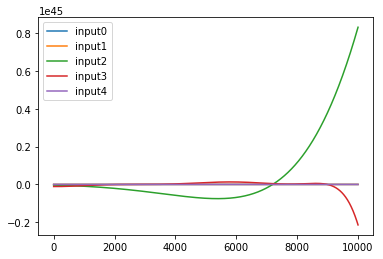

In [6]:
# Loop a few times to create more insteresting data:
for i in range(0, 5):
    df_dat_inp = gen_linear_comb(df_dat_inp, n_outputs=total_dims, col_prefix='input')
df_dat_inp = gen_linear_comb(df_dat_inp, n_outputs=15, col_prefix='input')

df_dat_inp.iloc[:,:5].plot()
plt.show()

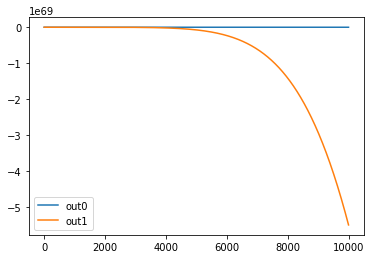

In [7]:
# Run once more to get an output dataset that is a linear combination of the input datasets
df_dat_out = gen_linear_comb(df_dat_inp, n_outputs=2)
df_dat_out.plot()
plt.show()

## Principal Components Regression

It's possible to perform regression by just using the output with PCA. This will capture the maximal variance per PCA component:

In [8]:
# Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.decomposition import PCA

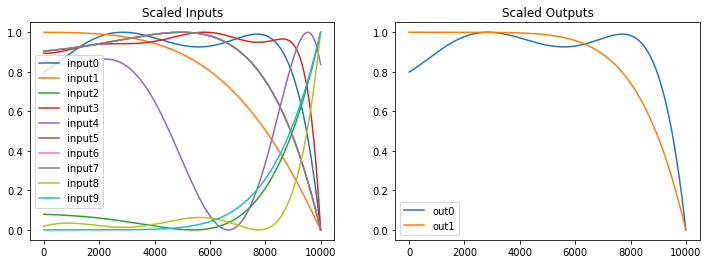

In [9]:
# Scale data via scaler object:
scaler_inputs = MinMaxScaler()
scaler_inputs.fit(df_dat_inp)
df_dat_n_inp = pd.DataFrame(data=scaler_inputs.transform(df_dat_inp), 
                         columns=df_dat_inp.columns)

scaler_outputs = MinMaxScaler()
scaler_outputs.fit(df_dat_out)
df_dat_n_out= pd.DataFrame(data=scaler_outputs.transform(df_dat_out), 
                         columns=df_dat_out.columns)


# Plot scaled inputs and outputs
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
df_dat_n_inp.iloc[:,:10].plot(title="Scaled Inputs", ax=ax1)
df_dat_n_out.plot(title="Scaled Outputs", ax=ax2)
plt.show()

In [10]:
# Perform PCA
# obtain explained variance and basis components:
pca_data = df_dat_n_inp
pca_4d = PCA().fit(pca_data)
expl_var_4d = pca_4d.explained_variance_
dat_n_4d_reduced = pca_4d.transform(pca_data)
#components_4d = pca_4d.components_

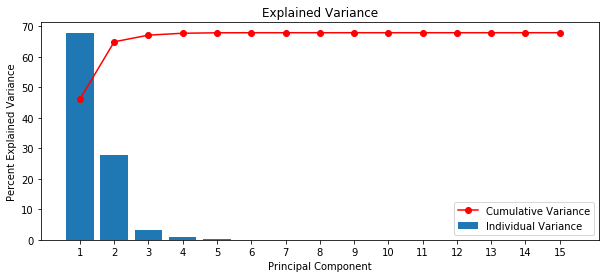

In [11]:
# Summarize explained Variance
tot = sum(expl_var_4d)
var_exp = [(i / tot)*100 for i in sorted(expl_var_4d, reverse=True)]
cum_var_exp = np.cumsum(expl_var_4d)*max(var_exp)/expl_var_4d.sum()

# Visualize explained variance:
xlabels = ['{}'.format(x) for x in range(1, len(var_exp)+1)]
fig = plt.figure(figsize=(10,4))
plt.bar(xlabels, var_exp, label='Individual Variance')
plt.plot(xlabels, 
         cum_var_exp, 
         label='Cumulative Variance', 
         marker='o', 
         color='red')
plt.ylabel('Percent Explained Variance')
plt.xlabel('Principal Component')
plt.title('Explained Variance')
plt.legend()
plt.show()

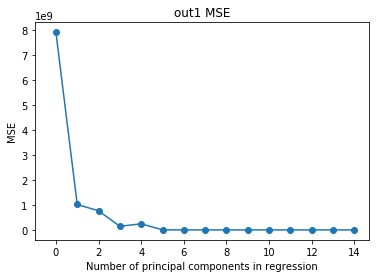

In [12]:
# Perform Regression on each additional component:
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.metrics import r2_score

# Set up the regression error detection:
kf_3 = model_selection.KFold(n_splits=10, 
                              shuffle=False, 
                              random_state=1)
# Run linear regression
target_varname = 'out1'

target_var = df_dat_n_out[target_varname]
regr = LinearRegression()
mse = []
for i in range(1, len(expl_var_4d)+1):
    score = -1*model_selection.cross_val_score(regr, 
                                               dat_n_4d_reduced[:,:i], 
                                               target_var.values, 
                                               cv=kf_3, 
                                               scoring='r2').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title(target_var.name+' MSE')
plt.xlim(xmin=-1);

Keep in mind just because we captured the overall variance by including $n$ principal components, it doesn't mean we've captured the variance that directly influences the target variable fit. 

In [13]:
# Return linear fit for number of principal components corresponding to the least error:
min_ind = mse.index(min(mse))+1 # Include the number of components up to the min (python is zero indexed)
regr_targ = LinearRegression()
regr_targ.fit(dat_n_4d_reduced[:,:min_ind], target_var)

eqn = ["{:.2g}".format(regr_targ.intercept_)] + ['*'.join(x) for x in zip(["{:.2g}".format(x) for x in regr_targ.coef_], 
                          ['PC' + str(x+1) for x in range(0,len(regr_targ.coef_))])]
eqn = target_var.name + ' = ' + ' + '.join(eqn)
print("Fit is:\n" + eqn)

Fit is:
out1 = 0.86 + -0.31*PC1 + -0.06*PC2 + 0.034*PC3 + 0.07*PC4 + 0.02*PC5 + 0.13*PC6 + -0.044*PC7 + 0.1*PC8 + -0.37*PC9 + -0.33*PC10 + -0.79*PC11 + -0.0031*PC12


<Figure size 432x288 with 0 Axes>

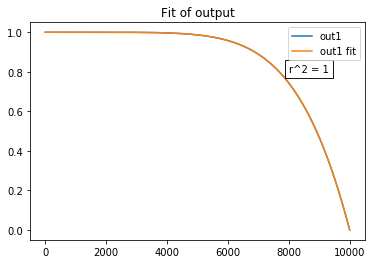

In [14]:
# Determine output of data:
data_in = df_dat_inp # Starting with dataset (happens to be our starting dataset, but could be some new data collected the same way as before)

data_in_n = scaler_inputs.transform(data_in) # Scale input according to scaler
data_in_n_pca = pca_4d.transform(data_in_n)[:,:min_ind] # Transform via PCA according to pca from training data
target_var_fit = regr_targ.predict(data_in_n_pca) # Regress to determine output fit
r2 = r2_score(target_var, target_var_fit)


# Plot Fit:
fig = plt.figure()
plot_df = pd.DataFrame(data=np.vstack([target_var, target_var_fit]).T,
             columns=[target_var.name, target_var.name+' fit'])
plot_df.plot(title='Fit of output')

r2text_coords = [0.8*int(plot_df.shape[0]), 
                 min(plot_df.min())+0.8*int(max(plot_df.max())-min(plot_df.min()))]
plt.text(r2text_coords[0], 
         r2text_coords[1], 
         'r^2 = {:.2g}'.format(r2),
         bbox=dict(facecolor='white', 
                   alpha=0.9))
plt.show()

## Projection to Latent Structures, Partial Least Squares (PLS)

Here, we use PLSRegression, which outputs a fit based on the target variable, not solely variance.

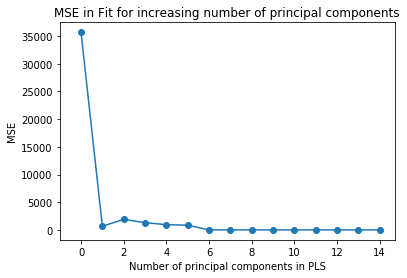

In [15]:
# Perform Regression on each additional component:
from sklearn.cross_decomposition import PLSRegression
import warnings   

# Transform Dataset
data_in = df_dat_inp # Starting with dataset (happens to be our starting dataset, but could be some new data collected the same way as before)
# no need to scale inputs - PLS does it by default
#data_in_n = scaler_inputs.transform(data_in) # Scale input according to scaler

# Set up the regression error detection:
kf_3 = model_selection.KFold(n_splits=3, 
                              shuffle=False, 
                              random_state=1)

# Run linear regression
target_var = df_dat_n_out[target_varname]
mse = []

with warnings.catch_warnings(): #remove specific warning for just this function
    warnings.filterwarnings("ignore", message=".*Y residual constant at iteration.*")
    
    for i in range(1, len(expl_var_4d)+1):
        pls = PLSRegression(n_components=i)
        score = -1*model_selection.cross_val_score(pls, 
                                                   data_in, 
                                                   target_var.values, 
                                                   cv=kf_3, 
                                                   scoring='r2').mean()
        mse.append(score)
    
# Plot results    
plt.plot(mse, '-o')
plt.xlabel('Number of principal components in PLS')
plt.ylabel('MSE')
plt.title('MSE in Fit for increasing number of principal components')
plt.xlim(xmin=-1);

In [16]:
# Return linear fit for number of components corresponding to the least error:
min_ind = mse.index(min(mse))+1 # Include the number of components up to the min (python is zero indexed)
pls_targ = PLSRegression(n_components=min_ind)
pls_targ.fit(data_in, target_var)

PLSRegression(copy=True, max_iter=500, n_components=11, scale=True, tol=1e-06)

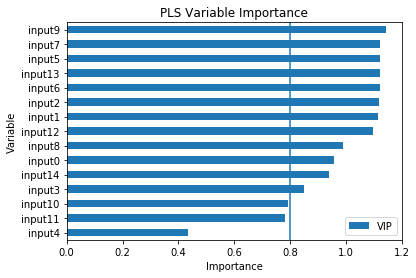

In [17]:
# PLS Variable Importance

# This is a good way to drop variables that aren't important according to the PLS fit, 
# dropping variables <0.8 is more or less a rule of thumb.
# Wold, S. (1994). “PLS for Multivariate Linear Modeling.” In QSAR: Chemometric Methods in Molecular Design. Methods and Principles in Medicinal Chemistry, edited by H. van de Waterbeemd, pp. 195–218. Weinheim, Germany: Verlag-Chemie.
# Eriksson, L., Johansson, E., Kettaneh-Wold, N., Trygg, J., Wikstrom, C., and Wold, S. (2006). Multi- and Megavariate Data Analysis Basic Principles and Applications (Part I). Chapter 4. Umetrics.
        
def vip(model):
  """ 
  PLS variable importance, taken from:
  https://github.com/scikit-learn/scikit-learn/issues/7050
  https://www.mathworks.com/matlabcentral/fileexchange/47767-libpls_1-95-zip  
  """
  t = model.x_scores_
  w = model.x_weights_
  q = model.y_loadings_
  p, h = w.shape
  vips = np.zeros((p,))
  s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
  total_s = np.sum(s)
  for i in range(p):
      weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
      vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
  return vips

# Determine variable importance:
var_imp = pd.DataFrame(index=data_in.columns, data={'VIP':vip(pls_targ)})
var_imp.sort_values('VIP', ascending=True, inplace=True)

# Plot variable importance:
var_imp[-15:].plot.barh(title='PLS Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.axvline(x=0.8) # Vertical line at 0.8
plt.show()

<Figure size 432x288 with 0 Axes>

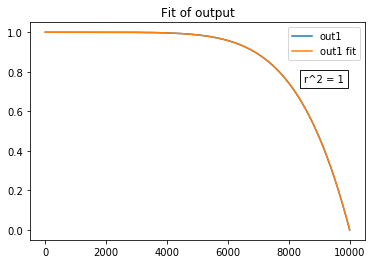

In [18]:
# Determine fit:

# Starting with dataset (happens to be our starting dataset, but could be some new data collected the same way as before)
data_in = df_dat_inp 

#data_in_n = scaler_inputs.transform(data_in) # Scale input according to scaler
target_var_fit = pls_targ.predict(data_in) # Regress to determine output fit
target_var_fit = target_var_fit.flatten() # Flatten output
r2 = r2_score(target_var, target_var_fit)

# Plot Fit:
fig = plt.figure()
plot_df = pd.DataFrame(data=np.vstack([target_var, target_var_fit]).T,
             columns=[target_var.name, target_var.name+' fit'])
plot_df.plot(title='Fit of output')

r2text_coords = [0.85*int(plot_df.shape[0]), 
                 min(plot_df.min())+0.75*int(max(plot_df.max())-min(plot_df.min()))]
plt.text(r2text_coords[0], 
         r2text_coords[1], 
         'r^2 = {:.2g}'.format(r2),
         bbox=dict(facecolor='white', 
                   alpha=0.9))
plt.show()